In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tqdm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import os


In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh', tsname ='Original'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [4]:
def plot_ts_and_points(tser, start_point, step):
    new_series = [None for i in range(len(tser))]
    for i in range(len(tser)):
        pos = start_point + step * i
        if pos >= len(tser):
            break
        new_series[pos] = tser[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        tser.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

In [5]:
os.chdir(r'd:\ml\временные ряды')

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


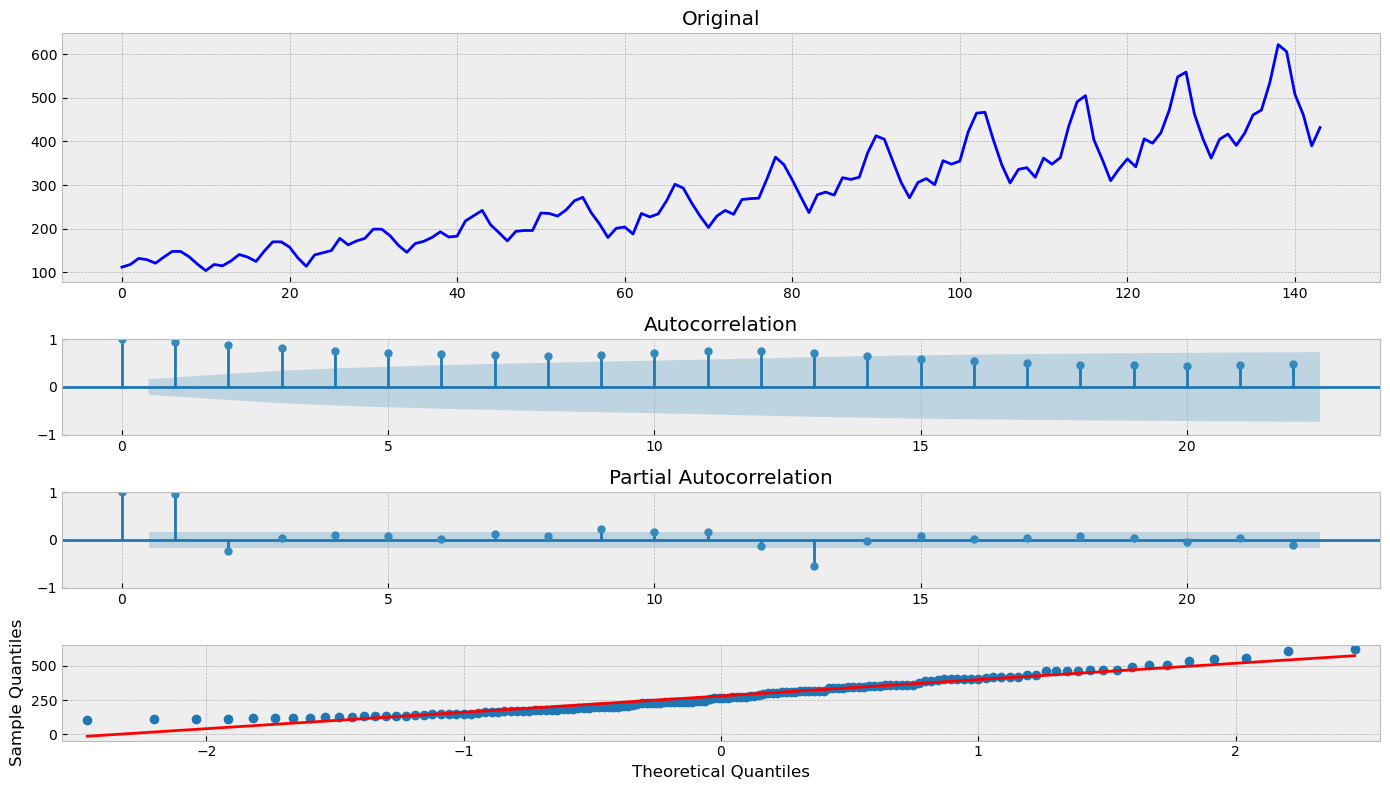

In [6]:
ts = pd.read_csv("Series/international-airline-passengers.csv")['Count']
nplt = 'international-airline-passengers'
tsplot(ts,tsname = nplt)

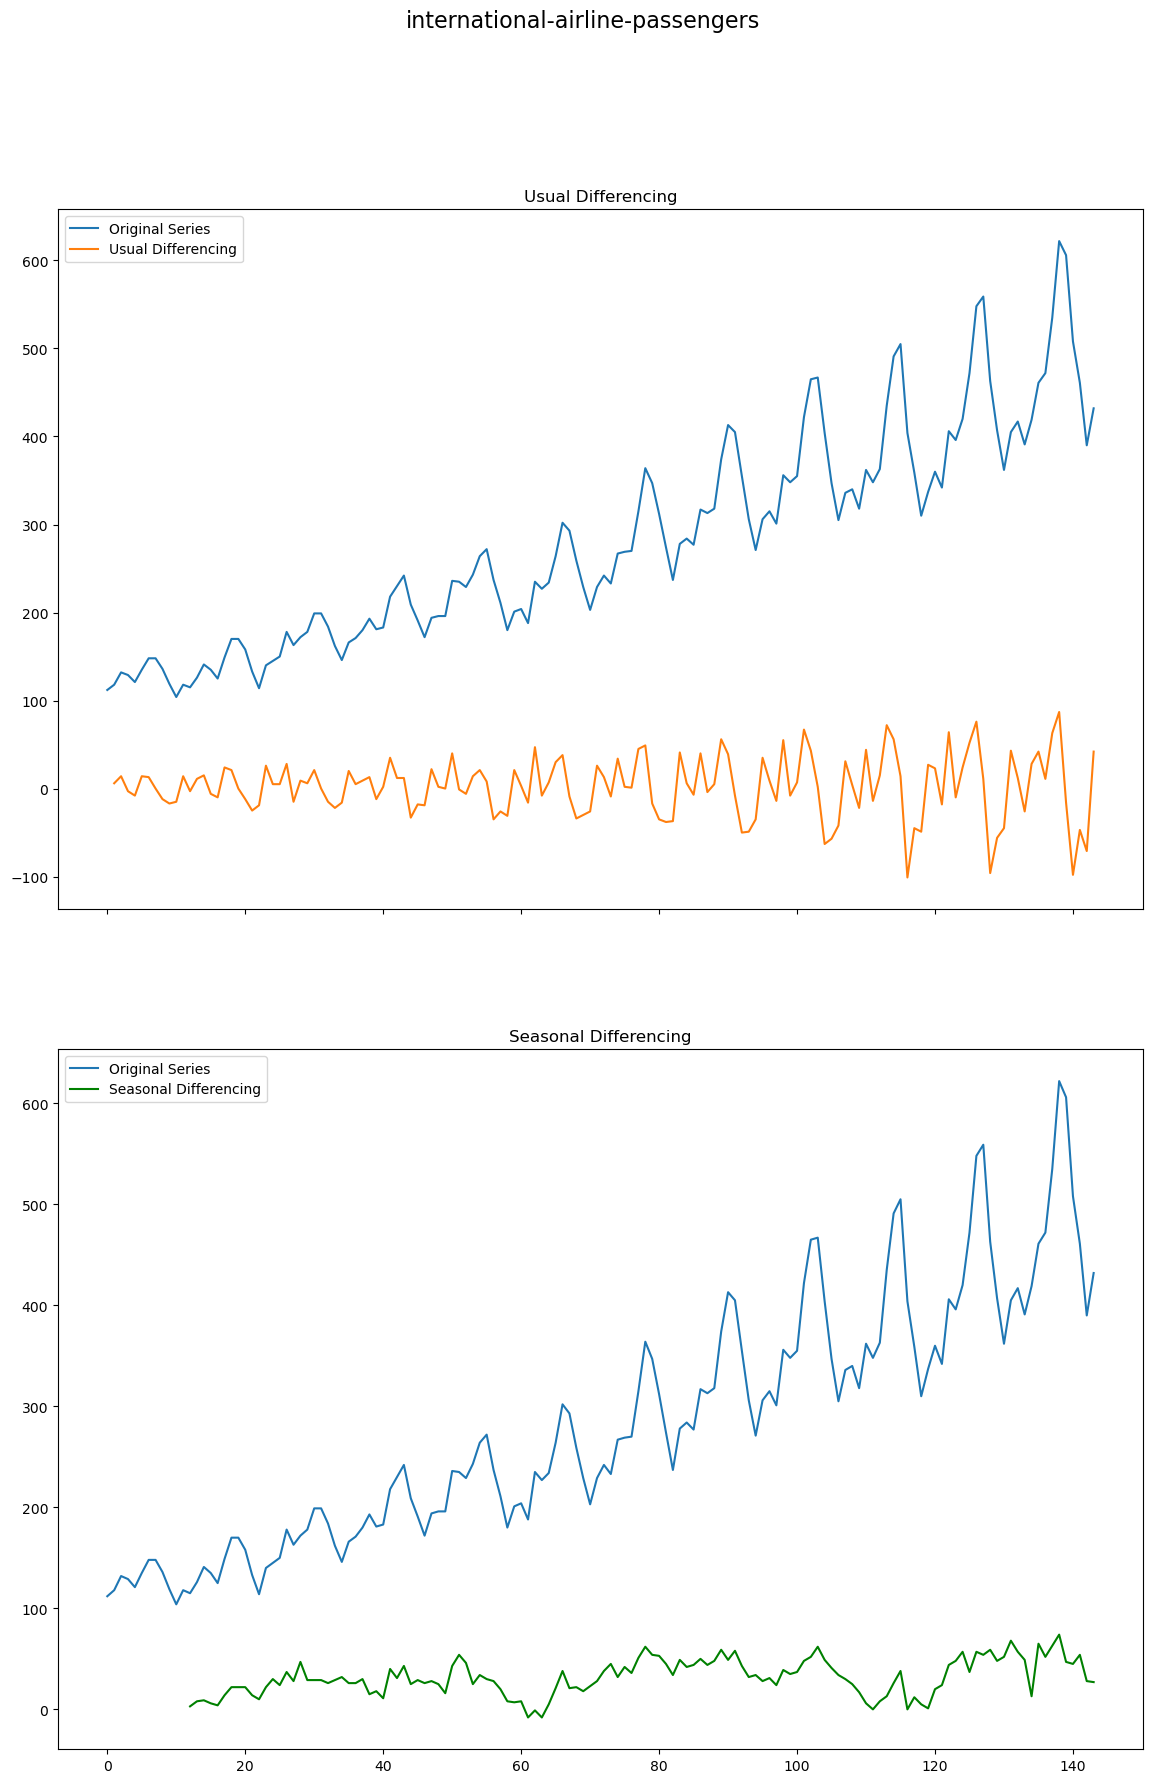

In [7]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(14,20), dpi=100, sharex=True)
#
# Usual Differencing
axes[0].plot(ts, label='Original Series')
axes[0].plot(ts.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(ts, label='Original Series')
axes[1].plot(ts.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('international-airline-passengers', fontsize=16)
plt.show()

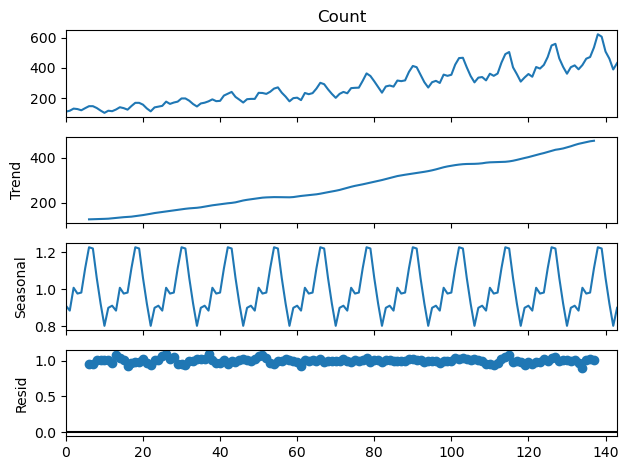

In [8]:
# проверим на сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(ts, model ='multiplicative', period = 12)
res.plot() 
plt.show()

Прослеживается явная сезонность. Мы можем видеть, что сезонные всплески становятся меньше после применения обычной дифференциации .После сезонной дифференциации они еще становятся меньше.

In [9]:
import itertools

In [10]:
p = range(0,10)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf
for params in pdq:
  model_test = ARIMA(ts, order = params)
  result_test = model_test.fit()
  if result_test.aic < best_aic:
    best_pdq = params
    best_aic = result_test.aic
print(best_pdq, best_aic)

(8, 2, 2) 1306.877509115509


In [11]:
model = ARIMA(ts, order = (8,2,2))
result = model.fit()

In [12]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Count   No. Observations:                  144
Model:                 ARIMA(8, 2, 2)   Log Likelihood                -642.439
Date:                Sat, 09 Mar 2024   AIC                           1306.878
Time:                        15:22:43   BIC                           1339.392
Sample:                             0   HQIC                          1320.090
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5688      0.104      5.488      0.000       0.366       0.772
ar.L2         -0.4429      0.101     -4.390      0.000      -0.641      -0.245
ar.L3         -0.0069      0.092     -0.075      0.940      -0.187       0.173
ar.L4         -0.4352      0.086     -5.079      0.000      -0.603      -0.267
ar.L5          0.1035      0.093      1.107      0.268      -0.080       0.287
ar.L6         -0.3236      0.092     -3.500      0.000      -0.505      -0.142
ar.L7          0.0648      0.083      0.785      0.432      -0.097       0.226
ar.L8         -0.5331      0.077     -6.880      0.000      -0.685      -0.381
ma.L1         -1.7088      0.107    -16.026      0.000      -1.918      -1.500
ma.L2          0.7094      0.093      7.659      0.000       0.528       0.891
sigma2       448.4748     56.682      7.912      0.000     337.379     559.570
===================================================================================
Ljung-Box (L1) (Q):                   2.02   Jarque-Bera (JB):                 3.99
Prob(Q):                              0.16   Prob(JB):                         0.14
Heteroskedasticity (H):               6.06   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
result.resid

0      112.000000
1      -50.028997
2        7.972424
3      -15.577379
4       -6.904224
          ...    
139     26.865680
140    -18.766485
141      7.893559
142    -40.444696
143     53.212003
Length: 144, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  -3.223683
p-value                          0.018654
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


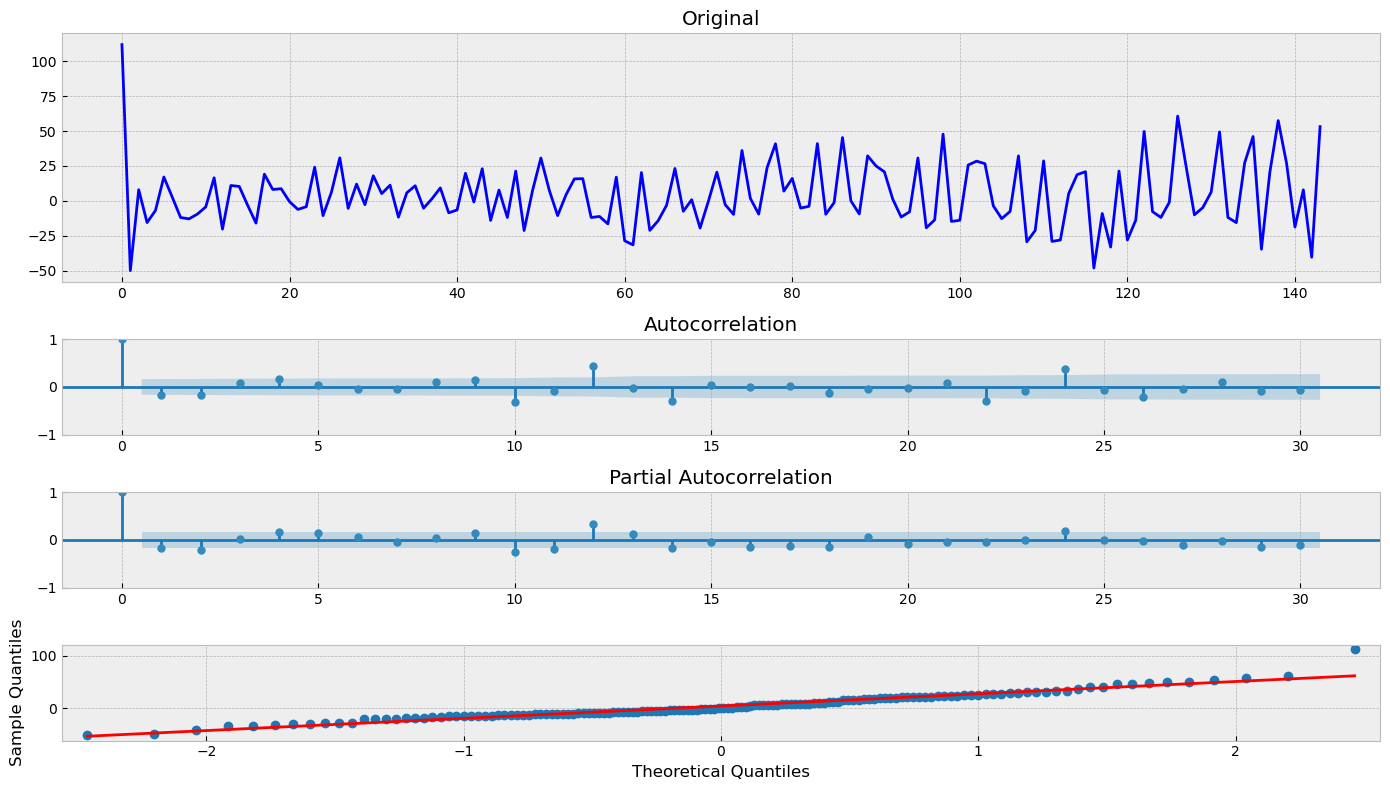

In [14]:
tsplot(result.resid, tsname = nplt, lags = 30)

мы не получили истинную модель. Модель нестационарная. Попробуем подобрать параметры с помощью пакета pmdarima и учета сезонности

In [15]:

import pmdarima as pm
model = pm.auto_arima(ts, start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.17 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.15 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.21 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.28 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.17 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.07 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(0,1,1)(1,1,1)[12]     

In [16]:
# В итоге сезонность 12 предлагаются следующие парметры модели pqd (2,1,0)[12]

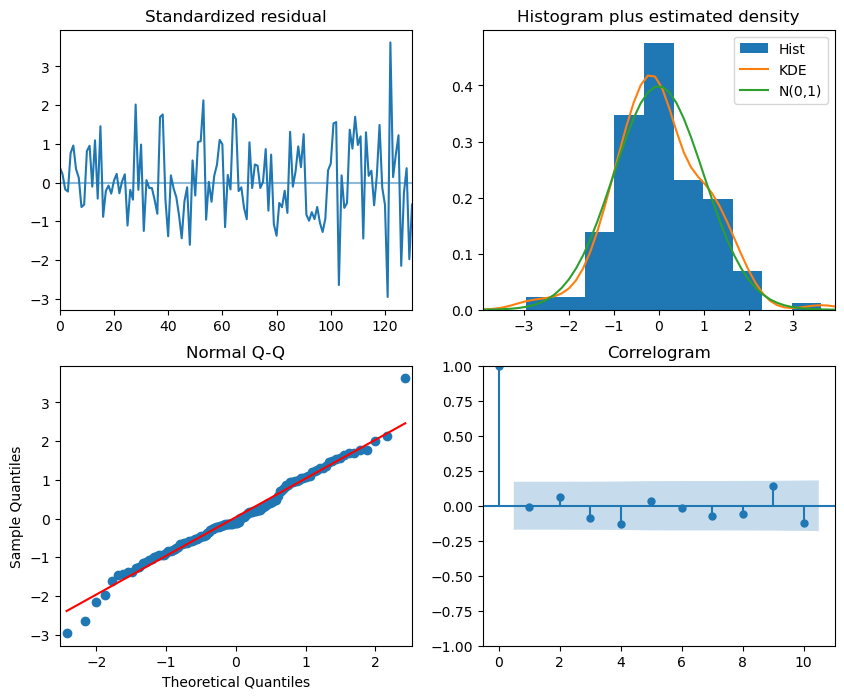

In [17]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

- Остаточные ошибки, по-видимому, колеблются вокруг среднего значения, равного нулю, и имеют равномерную дисперсию.
- Нормальное распределение
- Теоретические квантили: В основном точки идеально совпадают с красной линией за исключением старта и конца
-  остаточные ошибки не являются автокоррелированными
В целом модель подходит, берем ее для прогнозирования

In [18]:
n_periods = 12
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)

In [19]:
# предсказания 
fitted

144    451.347076
145    427.102222
146    463.382490
147    499.705770
148    514.035525
149    571.851867
150    661.310508
151    648.081675
152    551.284691
153    501.068279
154    434.052983
155    479.233767
dtype: float64

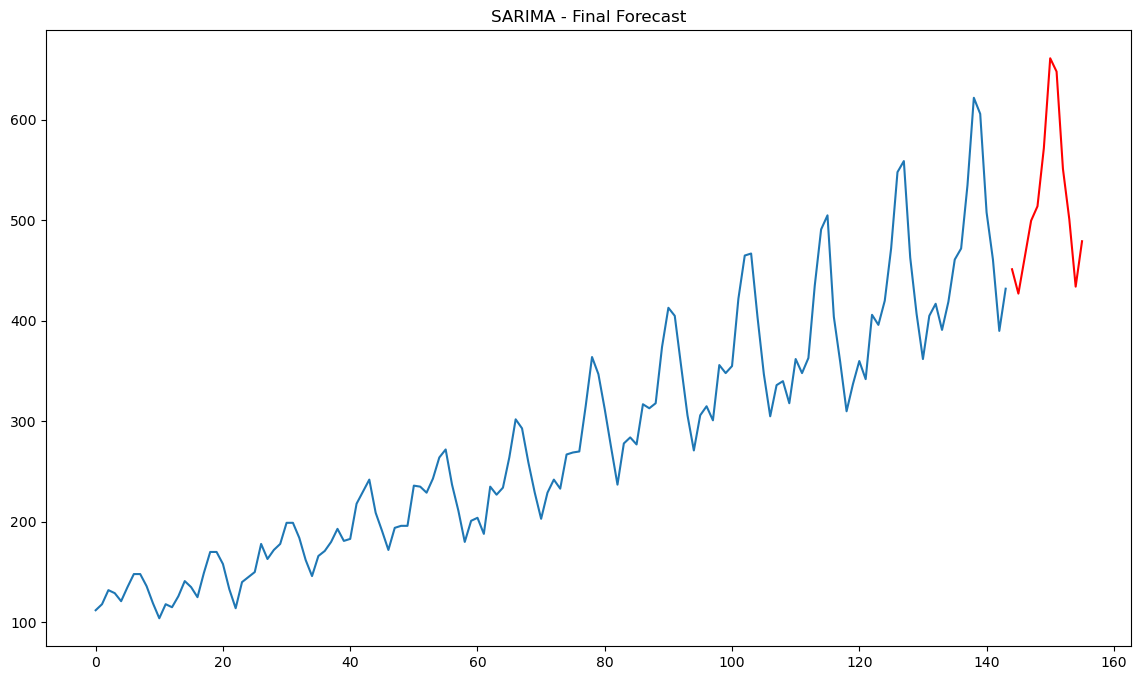

In [20]:

figsize=(14,8)
plt.figure(figsize=figsize)

plt.plot (ts)
plt.plot(fitted, color='red')

plt.title("SARIMA - Final Forecast")
plt.show()

Cпрогнозируем график классическим ML

In [21]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ['reg']
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['reg'].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["reg"], axis=1)
    y_train = data.loc[:test_index]["reg"]
    X_test = data.loc[test_index:].drop(["reg"], axis=1)
    y_test = data.loc[test_index:]["reg"]
    
    return X_train, X_test, y_train, y_test

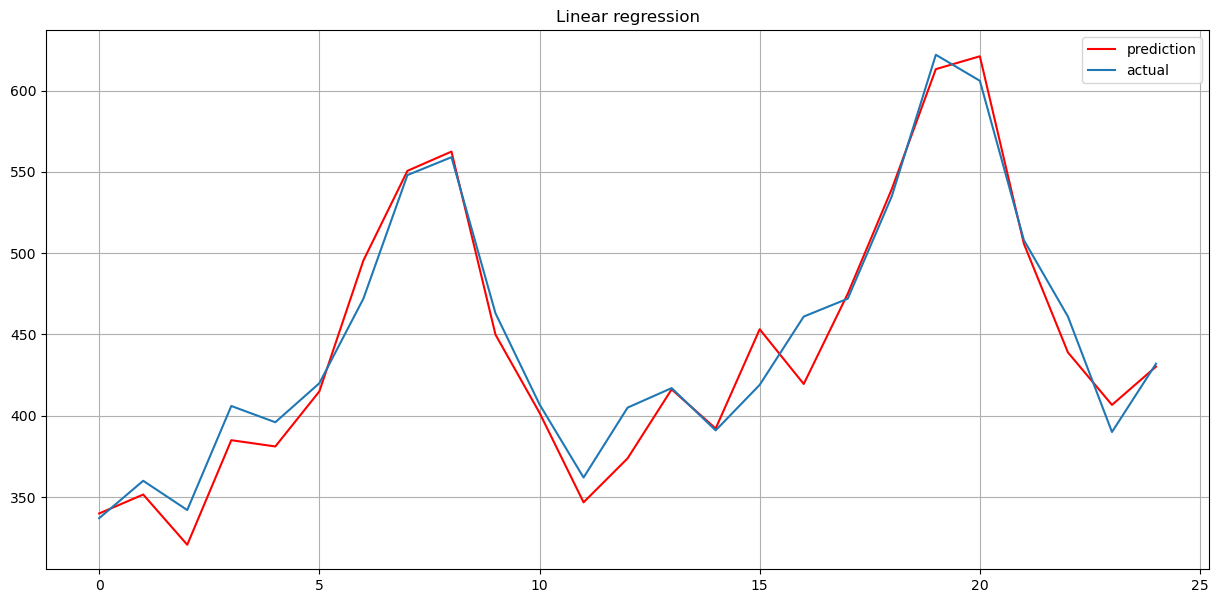

In [22]:
X_train, X_test, y_train, y_test = prepareData(ts, test_size=0.3, lag_start=1, lag_end=20)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title('Linear regression')
plt.grid(True);

На тестовых данных в этом конктетном временном ряде линйная регрессия показывает хороший результат